# Klasifikacija 3D oblika Perzistentnom homologijom

Ako podaci imaju neki, ljudima uočljiv oblik ili pravilnost, da li se ta osobina može iskoristiti kako bi se taj
skup podataka klasifikovao na neki način? Konkretnije, rad se bavi klasifikacijom skupa tačaka preko topoloških osobina prostora koje taj skup tačaka formira. 

Rad koristi osobine perzistentne homologoije kao feature nekog skupa podataka na kojem se mogu primeniti algoritmi
nadgledanog učenja. Informacije koje se dobiju perzistentnom homologijom možda nisu uvek pogodne kao jedini
feature, ali u slučaju kada podaci imaju različitu topologiju, mogu se koristiti kao dodatni feature za algoritme nadgledanog učenja.

Rad prvo demonstrira korišćenje perzistentne homologije nad podacima koji služe kao primer za primenu tehnike, a 
zatim i nad podskupom podataka [ShapeNet](https://shapenet.org/)

U pomocnoj skripti `generate_datasets` definisana je funkcija `make_point_clouds` koja pravi skup podataka koji
se koristi kao primer za ilustraciju perzistentne homologije. Kreirani skup podataka se sastoji od 4 klase oblika: 
krug, sfera, torus i dupli torus. Svaka klasa sadrzi `n_samples` oblaka tacaka i svaki oblak tacaka sadrzi `n_points` tacaka, sa izuzetkom torusa i duplog torusa koji sadrzi 3*`n_points` tacaka. Svaki oblik je generisan 
sa `noise` stepenom suma.

U pomocnoj skripti `model_processing` se nalaze funkcije za obradu i ucitavanje modela `shapenet` skupa podataka. 
Modeli skupa `shapenet` cesto imaju na desetine hiljada tacaka i trouglova. Kako bi se skratilo vreme treniranja
modeli su kompresiovani tehnikom `'simplification_quadric_edge_collapse_decimation'` biblioteke `pymeshlab`. 
Ova tehnika u vecini slucajeva cuva topologiju samog oblika i ne utice previse na kranji rezultat, ali 
zato drasticno smenjuje vreme izracunavanja perzistentne homologije.


In [1]:
import os
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

import model_processing
import generate_datasets
from importlib import reload
reload(model_processing)
reload(generate_datasets)

from gtda.diagrams import PersistenceEntropy, NumberOfPoints, Amplitude
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.pipeline import make_union



In [8]:
class Project:
    def __init__(self, name):
        assert name == 'example' or name == 'shapenet'
        self.name = name
        
        # Raw data
        self.models = None # {'label0': [point_cloud0, ...point_cloudN], 'label1':...}
        self.point_clouds = None # [point_cloud0, point_cloud1, ...point_cloudN] point_cloud.shape => (n,3)
        self.labels = None # [point_cloud0_label, ...point_cloudN_label]
        self.label_names = None # [label0, ..labelK]
        self.label_number = None # [0,1,...K]
        
        # Persistance data
        self.persistance_diagrams = None
        self.persistent_entropy = None

        # Data ready for traning
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        # Estimators
        self.grid_search_result = None
        self.estimator = None
        
        # Scoring
        self.y_test_pred = None
        self.confusion_matrix = None
        self.f1_score = None
        
        self.data_dir = 'data'
        self.output = widgets.Output()
        
    def load_data(self):
        if self.name == 'example':
            self.models = generate_datasets.make_point_clouds(n_samples_per_shape=10, n_points=20, noise=0.5)
        elif self.name == 'shapenet':
            self.models = {}
            for model_dir in os.listdir('data/shapenet/models'):
                if model_dir.startswith('.'):
                    continue
                self.models[model_dir] = model_processing.load_models(os.path.join('data/shapenet/models', model_dir))
            
        
        self.label_names = sorted([label for label in self.models.keys()])
        self.label_numbers = {label:number for number,label in enumerate(self.label_names)}
        self.point_clouds = []
        self.labels = []
        for label in self.label_names:
            point_cloud = self.models[label]
            self.point_clouds += point_cloud
            self.labels += [self.label_numbers[label] for _ in range(len(point_cloud))]
            
    def describe_data(self):
        for label, point_clouds in self.models.items():
            print(label, ":", len(point_clouds))
    
    def display_data(self):
        output = widgets.Output()
        def handle(change):
            output.clear_output()
            with output:
                display(change.owner)
                fig = plot_point_cloud(self.models[change.new][3])
                fig.show()
        selection = widgets.RadioButtons(options=[(key, key) for key in self.models.keys()])
        selection.observe(handler=handle, names=['value'])
        return output, selection
    
    def compute_persistance_diagrams(self):
        path_to_cached_results = os.path.join(self.data_dir, self.name, 'cached_results', 'persistance_diagrams')
        print(path_to_cached_results)
        if os.path.exists(path_to_cached_results):
            print('Loading from file: ')
            with open(path_to_cached_results, 'rb') as f:
                self.persistance_diagrams = pickle.load(f)
        else:
            print('Computing persistance diagrams')
            self.persistance_diagrams = list(zip(compute_persistance(self.point_clouds), self.labels))
            with open(path_to_cached_results, 'wb') as f:
                pickle.dump(self.persistance_diagrams, f)
    
    
    def display_persistance_diagrams(self):
        output = widgets.Output()
        def find_first_of_cat(dgms, cat):
            for dgm, c in self.persistance_diagrams:
                if c == cat:
                    return dgm
        def handle(change):
            output.clear_output()
            with output:
                display(change.owner)
                fig = plot_diagram(find_first_of_cat(self.persistance_diagrams, self.label_numbers[change.new]))
                fig.show()
        selection = widgets.RadioButtons(options=[(key, key) for key in self.models.keys()])
        selection.observe(handler=handle, names=['value'])
        return output, selection
    
    def compute_persistent_entropy(self):
        assert self.persistance_diagrams is not None
        path_to_cached_results = os.path.join(self.data_dir, self.name, 'cached_results', 'persistent_entropy')
        
        if os.path.exists(path_to_cached_results):
            print('Loading persitent entropy')
            with open(path_to_cached_results, 'rb') as f:
                self.persistent_entropy = np.load(f)
        else:
            print('Computing persitent entropy')
            dgms, label_numbers = list(zip(*self.persistance_diagrams))
            pers_entropy = PersistenceEntropy(n_jobs=14).fit_transform(dgms)
            self.persistent_entropy = np.hstack((pers_entropy, np.array(label_numbers).reshape(-1,1)))
            with open(path_to_cached_results, 'wb') as f:
                np.save(f, self.persistent_entropy)
        
        self.X = self.persistent_entropy[:,:-1]
        self.y = self.persistent_entropy[:,-1].astype('int32')
    
    def compute_enhanced_features(self):
        assert self.persistance_diagrams is not None
        path_to_cached_results = os.path.join(self.data_dir, self.name, 'cached_results', 'enhanced_features')
        
        
        if os.path.exists(path_to_cached_results):
            print('Loading cached results')
            with open(path_to_cached_results, 'rb') as f:
                self.enhanced_features = np.load(f)
        else:
            print('Computing enhanced features')
        
            feature_union = make_union(
                PersistenceEntropy(normalize=True),
                NumberOfPoints(n_jobs=-1)
            )
            
            dgms, label_numbers = list(zip(*self.persistance_diagrams))
            transformed = feature_union.fit_transform(dgms)
            self.enhanced_features = np.hstack((transformed, np.array(label_numbers).reshape(-1,1)))
            with open(path_to_cached_results, 'wb') as f:
                np.save(f, self.enhanced_features)
        
        self.X = self.enhanced_features[:,:-1]
        self.y = self.enhanced_features[:,-1].astype('int32')
        
        
    
    def display_persistent_entropy(self):
        fig = plot_point_cloud(self.X, plotly_params={
            'trace': {'marker':dict(color=self.y)}
        })
        fig.show()
    
    def train_test_split(self, test_size=0.3):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size)
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def grid_search_cv(self, estimator, params):
        clf = GridSearchCV(estimator, params, n_jobs=14)
        clf.fit(self.X_train, self.y_train)
        return clf
    
    def fit(self, estimator):
        estimator.fit(self.X_train, self.y_train)        
        return estimator
    
    def predict(self, estimator):
        return estimator.predict(self.y_test)
    
    def score(self, estimator):
        y_test_predict = estimator.predict(self.X_test)
        print('F1 score: ', f1_score(self.y_test, y_test_predict, average='weighted'))
        cros_eval = cross_val_score(estimator, self.X, self.y, cv=5)
        cv_scores = pd.DataFrame(cross_val_score(estimator, self.X, self.y, cv=5))
        print('Cross evaluation scores: ')
        print(cv_scores.describe())
        conf_matrix = confusion_matrix(self.y_test, y_test_predict)
        plot_confusion_matrix(conf_matrix, self.label_names)
    

    def get_persistent_entropy_as_dataframe(self):
        return pd.DataFrame(self.persistent_entropy, columns=['pe0', 'pe1', 'pe2', 'target'])

def compute_persistance(point_cloud, homology_dimensions=[0,1,2]):
    persistance = VietorisRipsPersistence(
        metric='euclidean', 
        homology_dimensions=homology_dimensions,
        n_jobs=12, # Stepen paralelizma
        collapse_edges=True
    )
    diagram_basic = persistance.fit_transform(point_cloud) # niz dijagrama. diagram_basic[i] je dijagram perzsitencije i-tog oblaka tacaka
    return diagram_basic
    
def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.xticks(ticks=[0,1,2,3], labels=labels)
    plt.ylabel('Actuals', fontsize=18)
    plt.yticks(ticks=[0,1,2,3], labels=labels)
    plt.title('Confusion matrix', fontsize=18)
    plt.show()

## Primer oblaka tačaka

Funkcija `make_point_clouds` generiše ukupno 40 oblaka tačaka u obliku kruga, sfere, torusa i duplog torusa različitih dimenzija. Po 10 oblaka tačaka iz svake kategorije.

In [9]:
point_clouds_basic = generate_datasets.make_point_clouds(n_samples_per_shape=10, n_points=20, noise=0.5)
point_clouds_basic.keys()

dict_keys(['circle', 'sphere', 'torus', 'double_torus'])

In [10]:
circle_point_cloud_example = point_clouds_basic['circle'][0]
sphere_point_cloud_example = point_clouds_basic['sphere'][0]
torus_point_cloud_example = point_clouds_basic['torus'][0]
double_torus_point_cloud_example =point_clouds_basic['double_torus'][0]

In [11]:
output = widgets.Output()
def handle(change):
    output.clear_output()
    with output:
        display(change.owner)
        fig = plot_point_cloud(point_clouds_basic[change.new][0])
        fig.show()
selection = widgets.RadioButtons(options=[(key, key) for key in point_clouds_basic.keys()])
selection.observe(handler=handle, names=['value'])
with output:
    display(selection)
output

Output()

In [12]:
example = Project('example')
example.load_data()
example.describe_data()

circle : 10
sphere : 10
torus : 10
double_torus : 10


In [13]:
out, sel = example.display_data()
with out:
    display(sel)
out

Output()

## Uvod u Perzistentnu homologiju

U ovom formatu podaci nisu pogodni za većinu algoritama mašinskog učenja. Kako bi podaci bili pogodni za većinu algoritama mašinskog učenja za klasifikaciju moraju biti u obliku matrice X. Svaka kolona ove matrice je neki
feature tog skupa podataka, a svaki red jedan uzorak iz tog skupa. Kako bi mogli da se primeni algoritmi nadgledanog učenja potrebno je da postoji i vektor labela y.

Kada bi svaki oblak tačaka iz skupa `point_clouds_basic` poredjali u jednu ovakvu matricu X, i u vektor y za
i-ti point cloud upisali kategoriju kojoj pripada, onda bi svaki red matrice X bio jedan point cloud.

Međutim, svaki point-cloud se sastoji od $n \in N$ tacaka gde je vaka tacka $x \in R^3$. To znači da bi svaki
point-cloud trebalo da bude jedna ćelija jednog reda ili da svaka tačka bude jedna ćelija (ali point-cloud-i ne moraju imati isti skup tačaka). U oba slučaja nije baš očigledno postaviti format. Drugi način bi možda bio
da napravimo X tako da ima tri kolone: X,Y,Z koordinatu, a onda da dodamo još jednu kolonu u kojoj bi pisalo
da li je to tačka sa kruga, torusa, sfere ili duplog torusa. To takođe nema smisla, jer šta znači da neke
3 koordinate pripadaju sfere? Sfera može biti definisana sa bilo kojojm tačkom. Ne zanima nas da li jedna pojedinačna tačka pripada nekom obliku, već da li ceo skup tačaka formira (nama na pogled) neki oblik koji ima
neke matematičke osobine.

Upravo se topologija bavi izučavanjem oblika i njihovih osobina. Topološko svojstvo ili topološka invarijanta je svojstvo topološkog prostora pod homeomorfizmom. Neformalno, ako zamislimo da je neki oblik (prostor) napravljen
od neke rastegljive gume, homeomorfizam rasteže, skuplja, gnječi...samo ako postoji rupa u toj gumi, ne sme da je popuni i ne sme da napravi novu rupu.

<img src="images/mug.gif" width="400" align="center">

Jedna od glavnih invarijanti koje topologija izučava su upravo ove rupe. Upravo tu topološku osobinu možemo iskoristiti kao nosioca neke informacije o podacima. Ostaje pitanje: kako je definisati tako da može da se predstavi i izračuna pomoću računara?

Za izvlačenje topoloških osobina oblaka tačaka koristićemo tzv. dijagrame perzistencije, ali kako bi smo stigli do dijagrama perzistencije i njegovog značenja moramo početi od osnovnih objekata ove oblasti matematike.

### Simplicijalni kompleks
https://brickisland.net/DDGSpring2016/2016/01/14/reading-1-the-simplicial-complex/

Simplicijalni kompleks je skup simpleksa koji zadovoljavaju određena matematička svojstva. Simpleks je generalizovan pojam trougla u proizvoljno dimenzija. Obično se naziva k-simpleks gde je k broj dimenzija simpleksa. Na primer:  
0-simpleks je tačka  
1-simpleks je duž  
2-simpleks je trougao (popunjena unutrašnjost)  
3-simpleks je tetrahedron (popunjena unutrašnjost itd)  
4-simpleks ...


<figure>
        <img src="images/simplicial_complex.png" width="400" align="center">
        <div align="center">Simplicijalni kompleks https://en.wikipedia.org/wiki/Simplicial_complex</div>
</figure>


Već možemo da uočimo da ovakav simplicijalni kompleks ima neke topološke osobine. Na primer simplicijalni kompleks koji sadrži dva 0-simpleksa ima dve komponente povezanosti. Simplicijalni kompleks koji sadrži 3 1-simpleksa takvih da formiraju trougao ima jednu komponentu povezanosti i jednu dvo-dimenzionu rupu (praznina u trouglu)...

Simplicijalni kompleksi su definisani na takav način da se ove topološke osobine (komponenti povezanosti, rupe...) mogu izračunati pomoću računara.

$$ X = \{a, b, c, d, e, \{a,b\}, \{b,c\}, \{c,d\}, \{d,e\}, \{b,e\}, \{a,e\}, \{a,b,e\}\} $$

<figure>
        <img src="images/2_complex.png" width="400" align="center">
        <div align="center">2-kompleks https://arxiv.org/abs/1904.11044</div>
</figure>

Računar može izračunati topološke osobine simplicijalnog kompleksa. Između ostalog možemo izračunati brojeve: povezanih komponenti, 1D rupa (kružnica i cilindar), 2D rupa (sfera) ...Ove vrednosti nazivaju se [Betijevi brojevi](https://en.wikipedia.org/wiki/Betti_number)
Neformalno, k-ti Betijev broj određuje broj k-dimenzionih rupa u topološkom prostoru.  Prva 3 Betijeva broja imaju sledeće značenje:  
$b0$ je broj povezanih komponenti  
$b1$ je broj jedno-dimenzionih rupa   
$b2$ je broj dvo-dimenzionih rupa (praznina)  

Na primer, za simplicijalni kompleks sa slike, Betijevi brojevi su:  
$b0 = 3$ broj povezanih komponenti  
$b1 = 1$ broj jedno-dimenzionih rupa  
$b2 = 1|0$  broj praznina  

Kakve ovo ima veze sa oblakom tačaka? Pa od oblaka tačaka možemo konstruisati abstraktni simplicijalni kompleks. Postoji više načina za konstrukciju simplicijalnog kompleksa od oblaka tačaka:  
1. [Vietoris-Rips kompleks](https://en.wikipedia.org/wiki/Vietoris%E2%80%93Rips_complex)
2. [Čehov kompleks](https://en.wikipedia.org/wiki/%C4%8Cech_complex)
3. [Kompleks svedoka](https://gudhi.inria.fr/doc/latest/group__witness__complex.html)
4. [Delone kompleks](https://courses.cs.duke.edu/fall06/cps296.1/Lectures/sec-III-3.pdf)
5. [Alpha compleks](https://gudhi.inria.fr/doc/latest/group__alpha__complex.html)
...

Za ovaj projekat koristićemo Vietoris-Rips kompleks (u nastavku Ripsov kompleks). Ripsov kompleks se konstruiše tako
što se oko svake tačke u skupu opiše kružnica prečnika $d$. Za svaku k-torku čije se kružnice međusobno seku doda se odgovarajući k-kompleks u simplicijalni kompleks tog skupa tačaka. 

<div align='center'>
<video width="80%" controls src="videos/rips_construction.mp4"/>
</div>
<center>
    [Mathew Wright - Introduction to Persistent homology](https://www.youtube.com/watch?v=h0bnG1Wavag)
</center>

Glavno pitanje je koja vrednost za $d$ je pogodna. Ukoliko je vrednost preniska ili previsoka, konstruisan Ripsov
kompleks neće nositi značajne informacije. Zbog toga se razmatraju sve $d\in\{0, R\}$ gde je R dovoljno veliko tako da se sve kružnice međusobno seku.

<figure>
        <img src="images/vietoris_rips_point_cloud.gif" width="600" align="center">
        <div align="center">Ripsovi kompleksi</div>
</figure>

Postoje alogritmi i strukture podataka koje određuju tačno na kojim vrednostima $d$ dolazi do promene simplicijalnog kompleksa i samo u tim vrednostima se računaju željene topološke osobine jer za sve druge vrednosti ostaju iste. 

Izračunavanjem Betijevih brojeva za sve ključne vrednosti $d$ možemo da pratimo koje topološke osobine ostaju, odnosno perzistiraju. Na pojmu Homologije se nećemo zadržavati jer prevazilazi okvire i potrebe ovog rada. 


Kada kažemo da se neka komponenta $H_{i}$ rodila to znači da se odgavarajući Betijev broj $b_{i}$ povećao za jedan. Kada kažemo da je neka komponenta $H_{i}$ nestala (umrla) tada se odgovarajući Betijev broj smanjio $b_{i}$ za jedan. 

Ono što nas zanima su upravo one komponente koje najduže perzistiraju kroz povećavanje
prečnika sfere kojim se formira niz Ripsovih kompleksa u kojima i posmatramo promene ovih
komponenti.

Stvaranje i nestajanje ovih komponenti može se predstaviti **dijagramom perzistencije**.

<figure>
        <img src="images/filtration.webp" width="800" align="center">
        <div align="center">Dijagram perzistencije https://www.nature.com/articles/s41598-021-84486-1</div>
</figure>

Opštije, N-ti Betijev broj označava rang n-te homološke grupe $H_{n}$. (Više na [linku](https://en.wikipedia.org/wiki/Persistent_homology)).


### Dijagrami perzistentcije

Koristimo biblioteku gtda kako bi izračunali dijagram perzistencije Ripsovog kompleksa. Funkcija `compute_persistance` kao prvi parametar uzima niz oblaka tačaka i za svaki računa dijagram prezistencije navedenih homoloških grupa iz drugog parametra.

In [14]:
example.compute_persistance_diagrams()

data/example/cached_results/persistance_diagrams
Computing persistance diagrams


In [15]:
out2, sel2 = example.display_persistance_diagrams()
with out2:
    display(sel2)
out2

Output()

In [16]:
sphere_and_circle = np.vstack([circle_point_cloud_example + 100, sphere_point_cloud_example])
plot_point_cloud(sphere_and_circle)

In [17]:
plot_diagram(compute_persistance([sphere_and_circle])[0])

In [18]:
sphere_and_circle_smaller = np.vstack([circle_point_cloud_example + 10, sphere_point_cloud_example])
plot_point_cloud(sphere_and_circle_smaller)

In [19]:
plot_diagram(compute_persistance([sphere_and_circle_smaller])[0])

## Perzistetna entropija

Dijagrami perzistencije daju uvid u neke topološke osobine prostora, ali su i dalje nepogodni za većinu algoritama mašinskog učenja. Postoji više načina da se dijagrami perzistencije vektoriziju. U ovom projektu koristićemo [Perzistentnu entropiju](https://giotto-ai.github.io/gtda-docs/latest/theory/glossary.html#persistence-entropy).

Perzistentna entropija meri entropiju tačaka na dijagramu perzistencije po homološkoj grupi. Preciznije, neka je 
$D=\{(b_{i}, d_{i})\}_{i\in I}$ dijagram perzistencije gde je $d_{i} < +\infty$. Tada, *perzistentnu entropiju* skupa $D$ definišemo sa $$E(D) = - \sum_{i \in I}{p_{i}log(p_{i})}$$ gde je $$p_i = \frac{(d_{i} - b_{i})}{L_{D}}$$   $$L_{D} = \sum_{i \in I}{(d_{i} - b_{i})}.$$

Perzistentna entropija se računa redom, za svaki skup tačaka D na dijagramu koje odgovaraju redom stvaranju i umiranju komponenti $H_{0}, H_{1}, H_{2}$ koje mere ove homolške grupe

In [20]:
example.compute_persistent_entropy()

Computing persitent entropy


In [21]:
example.persistent_entropy

array([[ 8.47384583,  4.79394775,  1.11334455,  0.        ],
       [ 8.44527948,  4.54673446,  1.08908409,  0.        ],
       [ 8.46442971,  4.60648745,  0.16447496,  0.        ],
       [ 8.46371548,  4.48048006,  0.85893867,  0.        ],
       [ 8.44666261,  4.61782313,  1.13983952,  0.        ],
       [ 8.45246505,  4.19005456,  0.86843197,  0.        ],
       [ 8.48401743,  4.56060736,  1.63599593,  0.        ],
       [ 8.45566342,  4.24576316,  0.        ,  0.        ],
       [ 8.43350183,  4.32497865,  0.90581652,  0.        ],
       [ 8.45264002,  4.31955727,  1.34127652,  0.        ],
       [10.70001186,  8.70502373,  6.15310857,  1.        ],
       [10.70133723,  8.58167389,  6.15491179,  1.        ],
       [10.69642827,  8.64496031,  6.31870711,  1.        ],
       [10.69636607,  8.50651312,  6.41449913,  1.        ],
       [10.69921259,  8.61252153,  6.25819755,  1.        ],
       [10.7050575 ,  8.64775491,  6.51543036,  1.        ],
       [10.70324349,  8.

In [22]:
example.display_persistent_entropy()

Sa grafikona se vidi da su grupe oštro razdvojene i da nema preklapanja. Do ovako jasne podele je došlo zato što su oblaci tačaka dovoljno različiti po svojim topološkim osobinama koje meri perzistentna homologija. 
Ovo nam pokazuje da perzistentna entropija slika oblake tačaka u vektore koji se mogu klasifikovati po uhvaćenim topološkim osobinama.

U ovom slučaju `KNeighborsClassifier` bi bio sasvim dovoljan. Vodimo računa da parametar `n_neighbors` ne bude drastično veći od broja elemenata u jednoj klasi jer bi onda i elementi iz bliskih klasa uticali na kranji rezultat kalsifikacije. Pošto oblaka tačaka ima po 10 u svakoj kategoriji stavićemo da `n_neighbors=4`.

In [23]:
example.train_test_split()
knn = example.fit(KNeighborsClassifier(n_neighbors=4))

F1 score:  1.0
Cross evaluation scores: 
         0
count  5.0
mean   1.0
std    0.0
min    1.0
25%    1.0
50%    1.0
75%    1.0
max    1.0


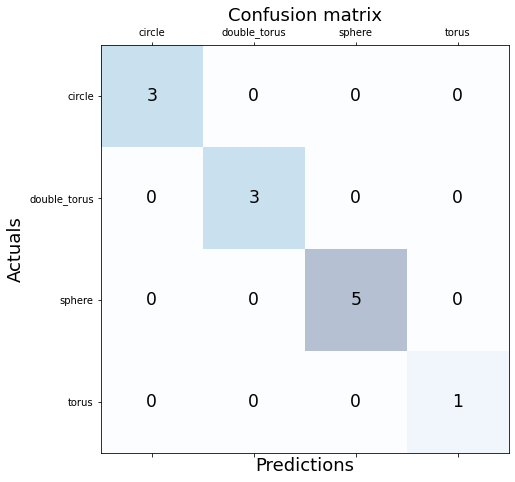

In [24]:
example.score(knn)

Ako rezultati deluju kao da su previse dobri da bi bili istiniti to je zato sto su podaci idealan slucaj za perzistentnu homologiju. 

U narednom delu cemo istu tehniku primeniti realan skup podataka.

# ShapeNet
ShapeNet je https://shapenet.org/ skup podataka 3D oblika nastao kao rezultat udruženog rada istraživača sa Prinstona, Stanforda i TTIC univerziteta kako bi olakšao istraživanje u oblasti grafike, računarskog vida, robotike i sličnih disciplina.

Iz ovoga skupa podataka izvučen je različit broja uzoraka oblika iz 4 kategrije:  avioni, bicikle, slušalice i činije. 

Istim pristupomom pokazaćemo kako perzitentna entropija nosi značajni deo informacija o topologiji oblika.

In [27]:
# Neki modeli imaju na desetine hiljada tačaka. Za izvlačenje topologije oblika nema potrebe da modeli budu
# toliko detaljni tako da ih geometrijskim metodama koje čuvaju topologiiju kompresujemo.
# for model_dir in os.listdir('data'):
#    model_processing.compress_models_in_dir(os.path.join('data', model_dir), 1000)

In [26]:
shapenet = Project('shapenet')
shapenet.load_data()
shapenet.describe_data()

01_bikes : 59
02_headphones : 73
00_bowl : 186
03_planes : 100


In [27]:
o3, s3 = shapenet.display_data() 
with o3:
    display(s3)
o3

Output()

In [28]:
shapenet.compute_persistance_diagrams()

data/shapenet/cached_results/persistance_diagrams
Computing persistance diagrams


In [29]:
o4, s4 = shapenet.display_persistance_diagrams()
with o4:
    display(s4)
o4

Output()

In [31]:
shapenet.compute_persistent_entropy()

Loading persitent entropy


In [32]:
shapenet.display_persistent_entropy()

Vidimo da podaci sada nisu tako jasno razdvojeni kao sto je to bio slucaj kod prostih oblika. Ima i preklapanja klasa. Tako da cemo ovde pokusati sa `SVC` modelom i uraditi pretragu parametara sa unakrsnom validacijom za parametre:  
C - parametar regularizacije
kernel - `poly` i `rbf` jer ce model u ovom slucaju tesko klase dobro razdvojiti hiper ravnima.



In [33]:
_ = shapenet.train_test_split()

In [34]:
svc_params = {
    'C': [0.01, 0.1, 1,5, 10, 50, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf'],
}
grid_search_result = shapenet.grid_search_cv(SVC(), svc_params)

In [35]:
grid_search_result.best_params_

{'C': 1000, 'kernel': 'rbf'}

In [36]:
grid_search_result.best_score_

0.7670952659263588

In [37]:
best_estimator = grid_search_result.best_estimator_

F1 score:  0.7524098124098125
Cross evaluation scores: 
              0
count  5.000000
mean   0.755881
std    0.033157
min    0.722892
25%    0.738095
50%    0.746988
75%    0.761905
max    0.809524


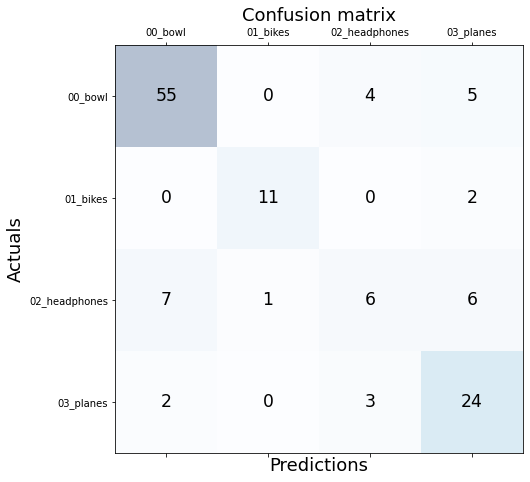

In [38]:
shapenet.score(best_estimator)

In [39]:
knn_params = {
    'n_neighbors':[1,3,5,10,20,30],
    'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1,2]
}
grid_search_results_knn = shapenet.grid_search_cv(KNeighborsClassifier(), knn_params)

In [40]:
grid_search_results_knn.best_params_

{'metric': 'chebyshev', 'n_neighbors': 5, 'p': 1}

In [41]:
grid_search_results_knn.best_score_

0.7808299240210403

In [42]:
best_knn_estimator = grid_search_result.best_estimator_


F1 score:  0.7524098124098125
Cross evaluation scores: 
              0
count  5.000000
mean   0.755881
std    0.033157
min    0.722892
25%    0.738095
50%    0.746988
75%    0.761905
max    0.809524


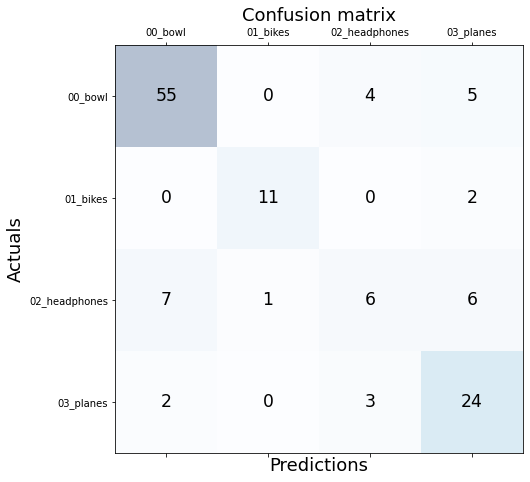

In [43]:
shapenet.score(best_knn_estimator)

## Dodavanje feature-a

Postoji jos mnostvo algoritama za izvlacanje dodatnih featurea iz perzistentne homologije pored perzistentne entropije. Na primer, jedan jednostavan feature koji mozemo iskoristiti je `NumberOfPoints` koji predstavlja broj tacaka van dijagonale.

Dodatni feature-i koji se mogu ubaciti: `Amplitude i ComplexPolynomial` iz paketa gtda.diagrams.

In [52]:
shapenet.compute_enhanced_features()

Loading cached results


In [53]:
_ = shapenet.train_test_split()

In [54]:
knn_params = {
    'n_neighbors':[1,3,5,10,20,30],
    'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1,2]
}
grid_search_results_knn = shapenet.grid_search_cv(KNeighborsClassifier(), knn_params)

In [55]:
grid_search_results_knn.best_score_

0.8255406195207481

F1 score:  0.7924624729009423
Cross evaluation scores: 
              0
count  5.000000
mean   0.825330
std    0.032451
min    0.785714
25%    0.795181
50%    0.843373
75%    0.845238
max    0.857143


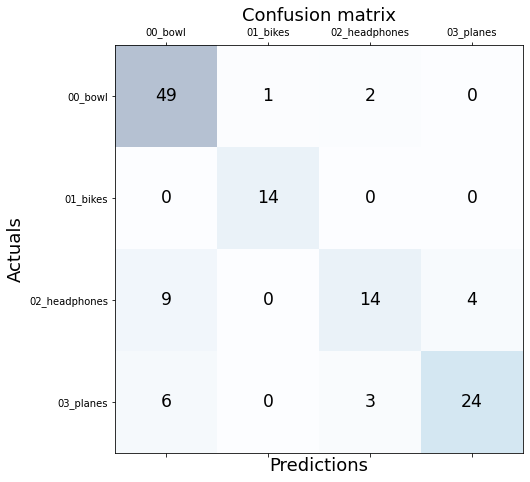

In [56]:
shapenet.score(grid_search_results_knn.best_estimator_)

## Pipeline

In [72]:
from gtda.pipeline import Pipeline
steps = [
    ("persistance", VietorisRipsPersistence(metric='euclidean', homology_dimensions=[0,1,2], n_jobs=14)),
    ("entropy", PersistenceEntropy()),
    ("model", KNeighborsClassifier())
]
pipeline = Pipeline(steps)

In [ ]:
pipeline.fit(point_clouds, labels)

## Zakljlučak

Videli smo da se perzistentna homologija ponasa idelano na skupu podataka skrojenom tako da ilustruje koje informacije oblaka tacka
perzistentna homologija izvlaci.

Na realnim podacima je situacija je uvek nesto losija, medjutim pokazali smo da se **perzistentna homologija moze koristiti
kao feature** za skupove podataka cije se klase razlikuju po topoloskim osobina koje perzistentna homologija izracunava.

Perzistentna homologija je samo jedan od alata u oblasti poznatoj kao "Topoloska analiza podataka". 
Neke od oblasti primena su: Kosmologija, obrada i analiza slika, proteina...
    
Neke od korisnih biblioteka:  
https://gudhi.inria.fr/

https://giotto-ai.github.io/gtda-docs/latest/library.html

Glavna ideja ove sveske zasnovana je na primeru: https://giotto-ai.github.io/gtda-docs/latest/notebooks/classifying_shapes.html

Za teorijsku osnovu odličan master rad kolege Filipa Jekića sa Matematičkog fakulteta: http://elibrary.matf.bg.ac.rs/bitstream/handle/123456789/5048/JekicFilip.pdf?sequence=1




## Reference 

Topološka analiza podataka: https://www.math.uri.edu/~thoma/comp_top__2018/Wasserman_2016_TopologicalDataAnalysis.pdf

Gudhi: https://gudhi.inria.fr/
Giotto: https://giotto-ai.github.io/gtda-docs/latest/library.html
Shapenet: https://shapenet.org/

Simplicijalni kompleks: https://brickisland.net/DDGSpring2016/2016/01/14/reading-1-the-simplicial-complex/
Betijevi brojevi: https://en.wikipedia.org/wiki/Betti_number
Ripsov kompleks: https://en.wikipedia.org/wiki/Vietoris%E2%80%93Rips_complex

Mathew Wright - Introduction to Persistent homology: https://www.youtube.com/watch?v=h0bnG1Wavag
Dijagrami perzistencije: https://www.nature.com/articles/s41598-021-84486-1
Perzistentna entropija: https://giotto-ai.github.io/gtda-docs/latest/theory/glossary.html#persistence-entropy